<a href="https://colab.research.google.com/github/shy00n123/solid-couscous/blob/main/Project_1_Congressional_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating the Influence of Political Party Affiliation and Education on High Levels of Household Income
In this notebook we will be using [American Community Survey(ACS)](https://www.census.gov/programs-surveys/acs/data.html) data from 2021 and some supplemental [Congressional District Data](http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv) to investigate a hypothesis that Democratic districts have a higher percentage of people with incomes higher than $200k because of a 4 Year Degree.

H0: Democratic congressional districts have a higher percentage of households with income over $200K independent of the % of people with 4-year degrees.

HA: Democratic congressional districts have a higher percentage of households with income over $200K because Democratic districts have a higher percentage of people with 4-year degrees.






### Importing Required Libraries


In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd  
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

### Importing ACS Data Including Households with Bachelor's Degree & Total Population Over 25 Years Old

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url2="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E,B15003_022E&for=congressional%20district:*&in=state:*"

url_female_over_25 = "https://api.census.gov/data/2021/acs/acs1?get=B01001_035E,B01001_036E,B01001_037E,\
B01001_038E,B01001_039E,B01001_040E,B01001_041E,B01001_042E,B01001_043E,\
B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E\
&for=congressional%20district:*&in=state:*"

url_male_over_25 = "https://api.census.gov/data/2021/acs/acs1?get=B01001_011E,B01001_012E,B01001_013E,\
B01001_014E,B01001_015E,B01001_016E,B01001_017E,B01001_018E,B01001_019E,\
B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E\
&for=congressional%20district:*&in=state:*"

# Store the response of URL
response = urlopen(url2)
responseFemale = urlopen(url_female_over_25)
responseMale = urlopen(url_male_over_25)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

data_json2 = json.loads(responseFemale.read())
data_json2.pop(0)

data_json3 = json.loads(responseMale.read())
data_json3.pop(0)

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
#cols = ['District Name','Total Households','Total Population','Bachelors Degree','Less than $10k', '$200k+', 'State code', 'district number']
#cols = ['District Name','Total Households','Total Population','Less than $10k', '$200k+', 'State code', 'district number']
cols = ['District Name','Total Households','Less than $10k', '$200k+', '4 Year Degree','State code', 'district number']
acs_df = pd.DataFrame(data_json, columns = cols)

femalesCols = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','State code', 'district number']
acs_df2 = pd.DataFrame(data_json2, columns = femalesCols)
acs_df2 = acs_df2.astype(str).astype(int)


malesCols = ['1','2','3', '4', '5','6', '7', '8', '9', '10', '11', '12', '13', '14', '15', 'State code', 'district number']
acs_df3 = pd.DataFrame(data_json3, columns = malesCols)
acs_df3 = acs_df3.astype(str).astype(int)


# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

acs_df['Total_females_25_plus'] = acs_df2.iloc[:,0:15].sum(axis=1)
acs_df['Total_males_25_plus'] = acs_df3.iloc[:,0:15].sum(axis=1)
acs_df['People 25+'] = acs_df[['Total_females_25_plus', 'Total_males_25_plus']].sum(axis=1)

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', '4 Year Degree','Less than $10k', "$200k+",'Total_females_25_plus','Total_males_25_plus', 'People 25+','district number', 'State']]

# Lets look at the resulting dataset
acs_df.head()

,Total Households,4 Year Degree,Less than $10k,$200k+,Total_females_25_plus,Total_males_25_plus,People 25+,district number,State
0,289474,80176,14153,19390,260624,253120,513744,10,Michigan
1,299804,80317,23793,10899,274996,251899,526895,4,Mississippi
2,278057,86334,27728,19574,249855,219914,469769,14,Michigan
3,306685,89086,19036,12208,258951,264112,523063,1,Michigan
4,285554,85809,26481,12412,261599,236826,498425,3,Mississippi


### Transforming the Data


In [ ]:
# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["4 Year Degree"] = pd.to_numeric(acs_df["4 Year Degree"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])
acs_df['People 25+'] = pd.to_numeric(acs_df['People 25+'])


# Compute some new columns based on the existing columns for later visualization
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']


# Normalize 4 Year degree with people above the age of 25
acs_df['% with 4-year degree'] = 100 * acs_df["4 Year Degree"] / acs_df['People 25+']


In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [ ]:
# Removing Libertarian districts from the dataset due to there being only a single observation
merged_df = merged_df[merged_df['Party'] != 'L']

# Create dummy variables for the political party column
dummy_df = pd.get_dummies(merged_df['Party'], prefix='Dummy')

# Concatenate the original DataFrame and the dummy variables DataFrame
merged_df = pd.concat([merged_df, dummy_df], axis=1)

merged_df = merged_df.drop('Dummy_R', axis = 1)

In [ ]:
merged_df.describe()

,Total Households,4 Year Degree,Less than $10k,$200k+,Total_females_25_plus,Total_males_25_plus,People 25+,district number,% of households over $200k,% of households less than $10k,% with 4-year degree,Dummy_D
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,292477.410138,111164.059908,17612.700461,28538.569124,268243.414747,255257.788018,523501.202765,10.175115,9.726725,6.052506,20.986468,0.536866
std,33709.431023,36407.545709,6053.283209,18921.413644,26285.551823,25108.407618,49781.946056,10.663517,6.424471,2.107973,5.826350,0.499214
min,183319.000000,25115.000000,6021.000000,5296.000000,192864.000000,182737.000000,385535.000000,0.000000,2.025905,2.208934,5.918143,0.000000
25%,273664.500000,84587.250000,13415.500000,14842.500000,251202.250000,239944.250000,492691.750000,3.000000,5.178620,4.644085,16.760914,0.000000
50%,292530.000000,106755.500000,16626.500000,22554.500000,266920.000000,252696.500000,520608.500000,6.000000,7.634268,5.683421,20.199213,1.000000
75%,312015.750000,136055.250000,21017.750000,37015.750000,282623.000000,266873.250000,547605.250000,13.000000,12.691753,7.039841,24.570000,1.000000
max,448949.000000,223981.000000,44929.000000,111988.000000,380390.000000,386368.000000,766758.000000,53.000000,41.846370,16.858153,39.175045,1.000000


# Performing the Analysis

In [ ]:
# Grouping by political party and taking the mean across all numerical columns
merged_df.groupby(['Party']).mean()

,Total Households,4 Year Degree,Less than $10k,$200k+,Total_females_25_plus,Total_males_25_plus,People 25+,district number,% of households over $200k,% of households less than $10k,% with 4-year degree,Dummy_D
Party,,,,,,,,,,,,
D,286861.536481,118384.502146,17859.635193,34135.103004,267085.287554,252364.163090,519449.450644,12.077253,11.81920,6.234996,22.501473,1.0
R,298987.353234,102794.094527,17326.452736,22051.044776,269585.920398,258612.089552,528198.009950,7.970149,7.30112,5.840964,19.230269,0.0


### Plotting % of households over $200k
Before this analysis we discovered that Democratic districts have a higher percentage of households with in an income over 200K than do Republicans as shown by the following box plot.



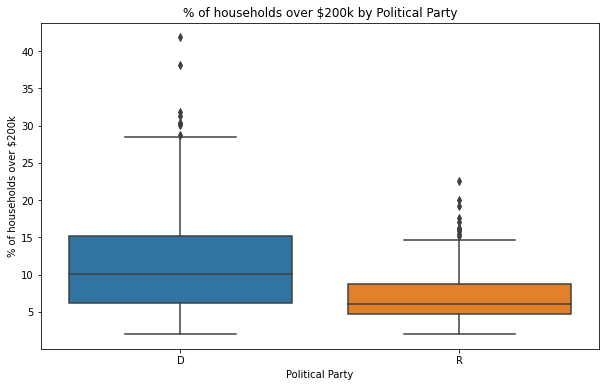

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Party', y='% of households over $200k', data=merged_df, order=["D", "R"])
plt.title("% of households over $200k by Political Party")
plt.xlabel("Political Party")
plt.ylabel("% of households over $200k")
plt.show()

In [ ]:
merged_df[['% of households over $200k','Party']].groupby(['Party']).describe()

% of households over $200k                                          \
                           count      mean       std       min       25%   
Party                                                                      
D                          233.0  11.81920  7.468370  2.049245  6.181057   
R                          201.0   7.30112  3.693666  2.025905  4.759436   

                                       
             50%        75%       max  
Party                                  
D      10.100090  15.149169  41.84637  
R       6.096713   8.739389  22.51190

###Exploring the number of 4-year Degrees within each party
We believe that this can be explained by % of the population in each district that has a bachelors degree. The following plot shows that Democratic districts are more educated on average.

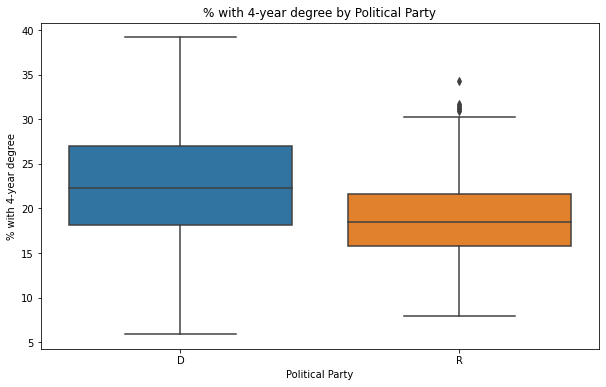

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Party', y='% with 4-year degree', data=merged_df, order=["D", "R"])
plt.title("% with 4-year degree by Political Party")
plt.xlabel("Political Party")
plt.ylabel("% with 4-year degree")
plt.show()

In [ ]:
merged_df[['% with 4-year degree','Party']].groupby(['Party']).describe()

% with 4-year degree                                            \
                     count       mean       std       min        25%   
Party                                                                  
D                    233.0  22.501473  6.286499  5.918143  18.105936   
R                    201.0  19.230269  4.677281  7.952670  15.758853   

                                        
             50%        75%        max  
Party                                   
D      22.293654  27.006439  39.175045  
R      18.492472  21.612051  34.263037

###Exploring the correlation between % with 4-year degree and the % of households over $200k

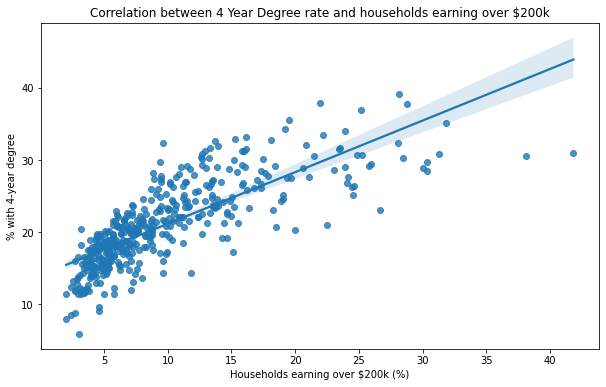

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x='% of households over $200k', y='% with 4-year degree', data=merged_df)
plt.title("Correlation between 4 Year Degree rate and households earning over $200k")
plt.xlabel("Households earning over $200k (%)")
plt.ylabel("% with 4-year degree")
plt.show()

In [ ]:
merged_df[['% with 4-year degree','% of households over $200k']].corr(method = 'pearson')


,% with 4-year degree,% of households over $200k
% with 4-year degree,1.000000,0.787192
% of households over $200k,0.787192,1.000000


### Exploring % of households over $200k with districts that have over 25% of people with 4-year degrees

Controlling for education level, we can still see that Democratic districts still have a higher % of households who earn over $200k.

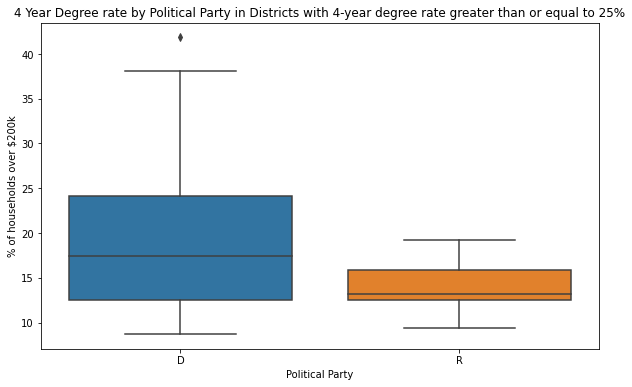

In [ ]:
# Controlling for a 4-year degree, and seeing if there still a difference in income between republicans and democrats

percent_greater_than_25 = merged_df[merged_df['% with 4-year degree'] >= 25]

plt.figure(figsize=(10,6))
sns.boxplot(x='Party', y='% of households over $200k', data=percent_greater_than_25, order=["D", "R"])
plt.title("4 Year Degree rate by Political Party in Districts with 4-year degree rate greater than or equal to 25%")
plt.xlabel("Political Party")
plt.ylabel("% of households over $200k")
plt.show()

In [ ]:
percent_greater_than_25[['% with 4-year degree','Party']].groupby(['Party']).describe()

% with 4-year degree                                             \
                     count       mean       std        min        25%   
Party                                                                   
D                     80.0  29.376940  3.171269  25.124761  26.906483   
R                     24.0  28.663891  2.289424  25.640915  26.872041   

                                        
             50%        75%        max  
Party                                   
D      28.892710  30.846496  39.175045  
R      28.232807  30.446941  34.263037

### Performing a regression analysis to determine siginificance 

Using Dummy_D as a dummy variable for political party, we can see that both Dummy D and % with 4-year degree are both highly significant at the 0.05 significance level.

The variable coeficients can be interpreted as the following:

For every one unit increase in % with 4-year degree, % of households over $200k increase by 0.82% on average, holding all other variables constant.

On average, the % of households over $200k is 1.8% higher than in Republican districts, holding all other variables constant.


In [ ]:
# Fit a multiple regression model
x = merged_df[['% with 4-year degree', 'Dummy_D']]
y = merged_df['% of households over $200k']

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
#predictions = model.predict(x) 


# Print the model summary
print_model = model.summary()
print(print_model)

# Calculate VIF Scores
vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_df = pd.DataFrame({"vif": vif[0:]}, index=x.columns)
print(vif_df)

                                OLS Regression Results                                
Dep. Variable:     % of households over $200k   R-squared:                       0.638
Model:                                    OLS   Adj. R-squared:                  0.636
Method:                         Least Squares   F-statistic:                     380.0
Date:                        Thu, 09 Feb 2023   Prob (F-statistic):           7.35e-96
Time:                                23:16:22   Log-Likelihood:                -1202.0
No. Observations:                         434   AIC:                             2410.
Df Residuals:                             431   BIC:                             2422.
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Conclusion:

 Based on this analysis, the story that it tells us is that the Democratic districts have a higher percentage of households with income over $200K independent of the % of people with 4-year degrees. 
 
We conclude that our initial hypothesis was correct and that we can conclude that democratic congressional districts have a higher percentage of households with income over $200K independent of the % of people with 4-year degrees.  

This conclusion, however, leaves us suspicious and skepitcal because we believe that education level is truly responsible for difference on the higher income between both parties. Our conclusion may have been this way because of factors such as multicolinearity issues between our variables. This would affect the true impact of the  percentage of 4 year degrees within the model and it might be worth it to look for more variables that remedy this issue.  